In [41]:
target = '(400.0, 100.0)'
is_notebook_mode = 'get_ipython' in globals()

import argparse


def parse_args(args_=None):
    parser = argparse.ArgumentParser()
    parser.add_argument("--target", type=str, default=target)
    args = parser.parse_args(args_)
    return args


if not is_notebook_mode:
    args = parse_args()
    target = args.target
target = eval(target)

use_plotly = False
try:
    import plotly.graph_objects as go
    use_plotly = is_notebook_mode
except:
    pass

In [42]:
from pathlib import Path

Path("figure").mkdir(exist_ok=True)
Path("visual").mkdir(exist_ok=True)

In [43]:
from pathlib import Path
from argparse import Namespace
import pandas as pd

assert Namespace

# Get all files with format '*.latency.csv' from root_dir
# root_dir = Path("fig11-abalation-log")
root_dir = Path("result")
latency_file_paths = sorted(list(root_dir.glob("*.latency.csv")))
experiment_log_paths = sorted(list(root_dir.glob("*.log")))
columns = ['backend', 'rate', 'target', 'attainment', 'latency']

In [44]:
dfs = []
namespaces = []
for latency_file_path, experiment_log_path in zip(latency_file_paths, experiment_log_paths):
    # read experiment_log_path and log the namespace
    # with open(experiment_log_path, 'r') as f:
    #     exp_args = f.read()
    #     exp_args = eval(exp_args)
    #     namespaces.append(exp_args)

    try:
        df = pd.read_csv(latency_file_path)
        dfs.append(df)
    except pd.errors.EmptyDataError:
        pass

In [45]:
big_df = pd.concat(dfs, ignore_index=True)
big_df['ngpu'] = big_df['tp_prefill'] * big_df['pp_prefill'] + big_df['tp_decode'] * big_df['pp_decode']
big_df['per_gpu_rate'] = big_df['rate'] / big_df['ngpu']
big_df['goodput@90'] = big_df.apply(
    lambda x: x['rate'] / x['ngpu'] if x['attainment'] >= 90 else 0,
    axis=1,
)

In [46]:
model_type = big_df['model_type'].unique()[0]
model_type

'OPT-66B'

In [47]:
big_df

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90
0,distserve,OPT-66B,prefill,0.25,400.0,76.0,2,1,1,2,4,0.0625,0.0000
1,distserve,OPT-66B,decode,0.25,100.0,100.0,2,1,1,2,4,0.0625,0.0625
2,distserve,OPT-66B,both,0.25,"(400.0, 100.0)",76.0,2,1,1,2,4,0.0625,0.0000
3,distserve,OPT-66B,prefill,0.25,160.0,34.0,2,1,1,2,4,0.0625,0.0000
4,distserve,OPT-66B,decode,0.25,40.0,0.0,2,1,1,2,4,0.0625,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,vllm,OPT-66B,decode,1.50,352.1811247101707,95.0,2,1,0,0,2,0.7500,0.7500
3496,vllm,OPT-66B,prefill,1.50,1010.3102702009419,98.0,2,1,0,0,2,0.7500,0.7500
3497,vllm,OPT-66B,decode,1.50,371.57849971925646,98.0,2,1,0,0,2,0.7500,0.7500
3498,vllm,OPT-66B,prefill,1.50,1040.089539713149,99.0,2,1,0,0,2,0.7500,0.7500


In [48]:
max_machine = 4
max_gpu_per_node = 8


def can_fit_low_affinity_distserve(x):
    a, b, c, d = x['tp_prefill'], x['pp_prefill'], x['tp_decode'], x['pp_decode']
    for pp_common in range(1, max_machine + 1):
        bp = b / pp_common
        dp = d / pp_common
        # If either bp or dp is not int, skip
        if int(bp) != bp or int(dp) != dp:
            continue
        # Check if the segment can be placed inside a node
        if a * bp + c * dp <= max_gpu_per_node:
            return True
        pass
    return False


def can_fit_low_affinity(x):
    if x['backend'] == 'distserve':
        return can_fit_low_affinity_distserve(x)
    else:
        return True
    pass


big_df['low_affin'] = big_df.apply(can_fit_low_affinity, axis=1)

In [49]:
big_df.sort_values(by=['backend', 'per_gpu_rate', 'tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode'])

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin
0,distserve,OPT-66B,prefill,0.25,400.0,76.0,2,1,1,2,4,0.0625,0.0000,True
1,distserve,OPT-66B,decode,0.25,100.0,100.0,2,1,1,2,4,0.0625,0.0625,True
2,distserve,OPT-66B,both,0.25,"(400.0, 100.0)",76.0,2,1,1,2,4,0.0625,0.0000,True
3,distserve,OPT-66B,prefill,0.25,160.0,34.0,2,1,1,2,4,0.0625,0.0000,True
4,distserve,OPT-66B,decode,0.25,40.0,0.0,2,1,1,2,4,0.0625,0.0000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,vllm,OPT-66B,decode,6.00,504.0970459045684,95.0,4,2,0,0,8,0.7500,0.7500,True
3321,vllm,OPT-66B,prefill,6.00,1641.1226124626305,98.0,4,2,0,0,8,0.7500,0.7500,True
3322,vllm,OPT-66B,decode,6.00,668.7474485094345,98.0,4,2,0,0,8,0.7500,0.7500,True
3323,vllm,OPT-66B,prefill,6.00,1689.821583500695,99.0,4,2,0,0,8,0.7500,0.7500,True


In [50]:
big_df['target_evaled'] = big_df['target'].apply(eval)
figure_11_left_df = big_df[
    (big_df['pd'] == 'both')
    & (big_df['target_evaled'] == target)
    ].copy()

figure_11_left_df = figure_11_left_df.sort_values(by=[
    'backend', 'tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode',
    'rate'
])
# Choose the config with the best goodput in each group
figure_11_distserve_high = figure_11_left_df[
    (figure_11_left_df['backend'] == 'distserve')
]
figure_11_distserve_low = figure_11_left_df[
    (figure_11_left_df['backend'] == 'distserve')
    & (figure_11_left_df['low_affin'])
    ]
figure_11_vllm_high = figure_11_left_df[
    (figure_11_left_df['backend'] == 'vllm')
]

if model_type == "OPT-13B": __tp=1
if model_type == "OPT-66B": __tp=2
if model_type == "OPT-175B": __tp=4
figure_11_vllm_low = figure_11_left_df[
    (figure_11_left_df['backend'] == 'vllm')
    & (figure_11_left_df['pp_prefill'] == 1)
    & (figure_11_left_df['tp_prefill'] == __tp)
    ]


In [51]:
figure_11_distserve_high

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin,target_evaled
2,distserve,OPT-66B,both,0.25,"(400.0, 100.0)",76.0,2,1,1,2,4,0.0625,0.00,True,"(400.0, 100.0)"
52,distserve,OPT-66B,both,0.50,"(400.0, 100.0)",72.0,2,1,1,2,4,0.1250,0.00,True,"(400.0, 100.0)"
102,distserve,OPT-66B,both,1.00,"(400.0, 100.0)",66.0,2,1,1,2,4,0.2500,0.00,True,"(400.0, 100.0)"
152,distserve,OPT-66B,both,1.50,"(400.0, 100.0)",53.0,2,1,1,2,4,0.3750,0.00,True,"(400.0, 100.0)"
202,distserve,OPT-66B,both,2.00,"(400.0, 100.0)",46.0,2,1,1,2,4,0.5000,0.00,True,"(400.0, 100.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,distserve,OPT-66B,both,2.00,"(400.0, 100.0)",93.5,4,1,4,1,8,0.2500,0.25,True,"(400.0, 100.0)"
2152,distserve,OPT-66B,both,3.00,"(400.0, 100.0)",84.0,4,1,4,1,8,0.3750,0.00,True,"(400.0, 100.0)"
2302,distserve,OPT-66B,both,4.00,"(400.0, 100.0)",77.0,4,1,4,1,8,0.5000,0.00,True,"(400.0, 100.0)"
2452,distserve,OPT-66B,both,5.00,"(400.0, 100.0)",65.0,4,1,4,1,8,0.6250,0.00,True,"(400.0, 100.0)"


In [52]:
figure_11_distserve_low

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin,target_evaled
2,distserve,OPT-66B,both,0.25,"(400.0, 100.0)",76.0,2,1,1,2,4,0.0625,0.00,True,"(400.0, 100.0)"
52,distserve,OPT-66B,both,0.50,"(400.0, 100.0)",72.0,2,1,1,2,4,0.1250,0.00,True,"(400.0, 100.0)"
102,distserve,OPT-66B,both,1.00,"(400.0, 100.0)",66.0,2,1,1,2,4,0.2500,0.00,True,"(400.0, 100.0)"
152,distserve,OPT-66B,both,1.50,"(400.0, 100.0)",53.0,2,1,1,2,4,0.3750,0.00,True,"(400.0, 100.0)"
202,distserve,OPT-66B,both,2.00,"(400.0, 100.0)",46.0,2,1,1,2,4,0.5000,0.00,True,"(400.0, 100.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,distserve,OPT-66B,both,2.00,"(400.0, 100.0)",93.5,4,1,4,1,8,0.2500,0.25,True,"(400.0, 100.0)"
2152,distserve,OPT-66B,both,3.00,"(400.0, 100.0)",84.0,4,1,4,1,8,0.3750,0.00,True,"(400.0, 100.0)"
2302,distserve,OPT-66B,both,4.00,"(400.0, 100.0)",77.0,4,1,4,1,8,0.5000,0.00,True,"(400.0, 100.0)"
2452,distserve,OPT-66B,both,5.00,"(400.0, 100.0)",65.0,4,1,4,1,8,0.6250,0.00,True,"(400.0, 100.0)"


In [53]:
figure_11_vllm_high

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin,target_evaled
3327,vllm,OPT-66B,both,0.125,"(400.0, 100.0)",62.0,2,1,0,0,2,0.0625,0.0,True,"(400.0, 100.0)"
3352,vllm,OPT-66B,both,0.250,"(400.0, 100.0)",62.0,2,1,0,0,2,0.1250,0.0,True,"(400.0, 100.0)"
3377,vllm,OPT-66B,both,0.500,"(400.0, 100.0)",58.0,2,1,0,0,2,0.2500,0.0,True,"(400.0, 100.0)"
3402,vllm,OPT-66B,both,0.750,"(400.0, 100.0)",56.0,2,1,0,0,2,0.3750,0.0,True,"(400.0, 100.0)"
3427,vllm,OPT-66B,both,1.000,"(400.0, 100.0)",48.0,2,1,0,0,2,0.5000,0.0,True,"(400.0, 100.0)"
3452,vllm,OPT-66B,both,1.250,"(400.0, 100.0)",32.0,2,1,0,0,2,0.6250,0.0,True,"(400.0, 100.0)"
3477,vllm,OPT-66B,both,1.500,"(400.0, 100.0)",28.0,2,1,0,0,2,0.7500,0.0,True,"(400.0, 100.0)"
2627,vllm,OPT-66B,both,0.250,"(400.0, 100.0)",66.0,2,2,0,0,4,0.0625,0.0,True,"(400.0, 100.0)"
2677,vllm,OPT-66B,both,0.500,"(400.0, 100.0)",60.0,2,2,0,0,4,0.1250,0.0,True,"(400.0, 100.0)"
2727,vllm,OPT-66B,both,1.000,"(400.0, 100.0)",26.0,2,2,0,0,4,0.2500,0.0,True,"(400.0, 100.0)"


In [54]:
figure_11_vllm_low

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,low_affin,target_evaled
3327,vllm,OPT-66B,both,0.125,"(400.0, 100.0)",62.0,2,1,0,0,2,0.0625,0.0,True,"(400.0, 100.0)"
3352,vllm,OPT-66B,both,0.250,"(400.0, 100.0)",62.0,2,1,0,0,2,0.1250,0.0,True,"(400.0, 100.0)"
3377,vllm,OPT-66B,both,0.500,"(400.0, 100.0)",58.0,2,1,0,0,2,0.2500,0.0,True,"(400.0, 100.0)"
3402,vllm,OPT-66B,both,0.750,"(400.0, 100.0)",56.0,2,1,0,0,2,0.3750,0.0,True,"(400.0, 100.0)"
3427,vllm,OPT-66B,both,1.000,"(400.0, 100.0)",48.0,2,1,0,0,2,0.5000,0.0,True,"(400.0, 100.0)"
3452,vllm,OPT-66B,both,1.250,"(400.0, 100.0)",32.0,2,1,0,0,2,0.6250,0.0,True,"(400.0, 100.0)"
3477,vllm,OPT-66B,both,1.500,"(400.0, 100.0)",28.0,2,1,0,0,2,0.7500,0.0,True,"(400.0, 100.0)"


In [55]:
if use_plotly:
    # Plot the `figure_11_distserve_high`for some configurations
    # tp_prefill = 1, pp_prefill = 1, tp_decode = 1, pp_decode = 1
    # x-axis: rate
    # y-axis: attainment
    # find all combination of tp_prefill, pp_prefill, tp_decode, pp_decode
    import plotly.graph_objects as go
    
    fig = go.Figure()
    configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
    df = figure_11_distserve_high
    
    for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
        config_df = df[
            (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
            (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
            ]
        # plot this inside a plotly plot
        fig.add_trace(go.Scatter(
            x=config_df['per_gpu_rate'], y=config_df['attainment'],
            mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
        ))
    
    # fig add title
    fig.update_layout(
        title="DistServe",
        xaxis_title="Per-GPU Rate (tokens/s)",
        yaxis_title="Attainment (%)",
        legend_title="Configuration"
    )

    # Export to html
    fig.write_html("visual/figure_11_distserve_high.html")
    if is_notebook_mode:
        fig.show()

In [56]:
if use_plotly:
    # Plot the `figure_11_vllm_high`for some configurations
    # tp_prefill = 1, pp_prefill = 1
    # x-axis: rate
    # y-axis: attainment
    # find all combination of tp_prefill, pp_prefill
    import plotly.graph_objects as go
    
    fig = go.Figure()
    configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
    df = figure_11_vllm_high
    
    for tp_prefill, pp_prefill in configs.values:
        config_df = df[
            (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
            ]
        # plot this inside a plotly plot
        fig.add_trace(go.Scatter(
            x=config_df['per_gpu_rate'], y=config_df['attainment'],
            mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vllm"
        ))
    
    # fig add title
    fig.update_layout(
        title="vLLM++",
        xaxis_title="Per-GPU Rate (tokens/s)",
        yaxis_title="Attainment (%)",
        legend_title="Configuration"
    )
    # Export to html
    fig.write_html("visual/figure_11_vllm_high.html")
    if is_notebook_mode:
        fig.show()

In [57]:
if use_plotly:
    import plotly.graph_objects as go
    
    fig = go.Figure()
    
    # Plot the `figure_11_distserve_high`for some configurations
    # tp_prefill = 1, pp_prefill = 1, tp_decode = 1, pp_decode = 1
    # x-axis: rate
    # y-axis: attainment
    # find all combination of tp_prefill, pp_prefill, tp_decode, pp_decode
    
    configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
    df = figure_11_distserve_high
    
    for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
        config_df = df[
            (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
            (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
            ]
        # plot this inside a plotly plot
        fig.add_trace(go.Scatter(
            x=config_df['per_gpu_rate'], y=config_df['attainment'],
            mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
        ))
    
    # Plot the `figure_11_vllm_high`for some configurations
    # tp_prefill = 1, pp_prefill = 1
    # x-axis: rate
    # y-axis: attainment
    # find all combination of tp_prefill, pp_prefill
    
    configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
    df = figure_11_vllm_high
    
    for tp_prefill, pp_prefill in configs.values:
        config_df = df[
            (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
            ]
        # plot this inside a plotly plot
        fig.add_trace(go.Scatter(
            x=config_df['per_gpu_rate'], y=config_df['attainment'],
            mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vllm"
        ))
    
    # fig add title
    fig.update_layout(
        title="Figure 11: Abalation Study (DistServe and vLLM)",
        xaxis_title="Per-GPU Rate (tokens/s)",
        yaxis_title="Attainment (%)",
        legend_title="Configuration"
    )
    fig.write_html("visual/figure_11.full.html")
    if is_notebook_mode:
        fig.show()

In [58]:
# Find the best config that has the highest goodput@90 and attainment
def get_top_config(df):
    max_per_gpu_rate = max(df['per_gpu_rate'].unique())
    df2 = df[df['per_gpu_rate'] == max_per_gpu_rate]
    df3 = df2.sort_values(by=['goodput@90', 'attainment'], ascending=False, )
    r = df3.iloc[0][[
        "tp_prefill",
        "pp_prefill",
        "tp_decode",
        "pp_decode",
    ]]
    return r


def add_plotly_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.add_trace(go.Scatter(
        x=config_df['per_gpu_rate'], y=config_df['attainment'],
        mode='lines+markers', name=name
    ))
    return

In [59]:
if use_plotly:
    import plotly.graph_objects as go
    
    fig = go.Figure()
    add_plotly_trace(fig, figure_11_distserve_high, "disthigh")
    add_plotly_trace(fig, figure_11_distserve_low, "distlow")
    add_plotly_trace(fig, figure_11_vllm_high, "vllm++")
    add_plotly_trace(fig, figure_11_vllm_low, "vllm")
    fig.update_layout(
        title="Figure 11: Abalation Study (DistServe and vLLM)<br>"
              "<sup>The figure shows that DistHigh > DistLow > vLLM++ > vLLM (vLLM++ and vLLM overlaps) </sup>",
        xaxis_title="Per-GPU Rate (tokens/s)",
        yaxis_title="Attainment (%)",
        legend_title="Configuration"
    )
    fig.write_html("visual/figure_11.html")
    if is_notebook_mode:
        fig.show()


In [60]:

def add_matplotlib_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.plot(
        config_df['per_gpu_rate'], config_df['attainment'],
        label=name,
        marker='o',
    )
    return config_df['attainment'].tolist()

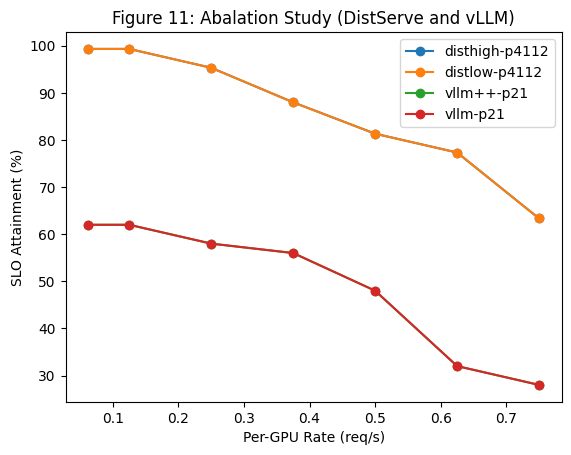

In [61]:
import matplotlib.pyplot as plt

# Plot a line chart with 4 curves
# x-axis: per_gpu_rate
# y-axis: attainment

fig, ax = plt.subplots()
a = add_matplotlib_trace(ax, figure_11_distserve_high, "disthigh")
b = add_matplotlib_trace(ax, figure_11_distserve_low, "distlow")
c = add_matplotlib_trace(ax, figure_11_vllm_high, "vllm++")
d = add_matplotlib_trace(ax, figure_11_vllm_low, "vllm")

plt.title("Figure 11: Abalation Study (DistServe and vLLM)")
plt.xlabel("Per-GPU Rate (req/s)")
plt.ylabel("SLO Attainment (%)")
plt.legend()
fig.savefig("figure/figure_11a.png")
if is_notebook_mode:
    plt.show()


In [62]:
data_points = {
    "dist++": a,
    "dist": b,
    "vllm++": c,
    "vllm": d,
}
with open("figure/figure_11a.json", "w") as f:
    import json

    json.dump(data_points, f)